# \<setup>

In [1]:
DATA_NAME = 'agrivision-full' 
TRANSFORM = 'wavelet-horizVert'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name of the result notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name of the result notebook:
red_horizVert_wavelet_full_agrivision.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
RES_DIR = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)
CWD = os.path.join(ROOT_DIR, 'anderson-darling')
assert CWD == os.getcwd()

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')

In [4]:
from testing_ad import *
os.chdir(os.path.join(ROOT_DIR, 'utilities'))
from testing import *
from plotting import *
os.chdir(CWD)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 9000,
 3: 36000,
 4: 144000,
 5: 576000,
 6: 2304000,
 7: 9216000,
 8: 36864000,
 9: 147456000,
 10: 589824000}

Running 12760 CDFs


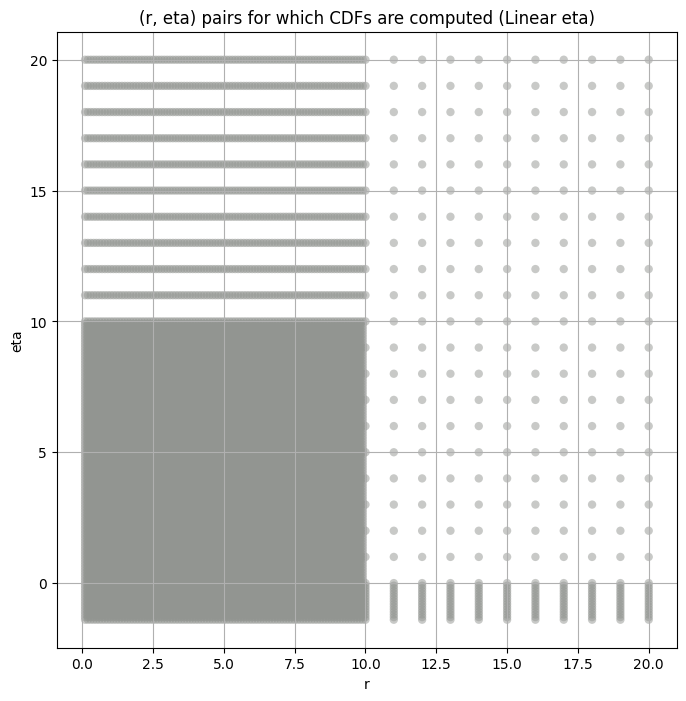

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

In [8]:
master_df_optimized_path = Path(os.path.join(RES_DIR, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(RES_DIR, "cache", "rEtaKsstats_dict.pickle"))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)

# \</setup>

In [9]:
group = 4
sample = group_data_map[group]
size, n = len(sample), group_total_samples[group]
print(size, 'subsampled from', n)

100000 subsampled from 144000


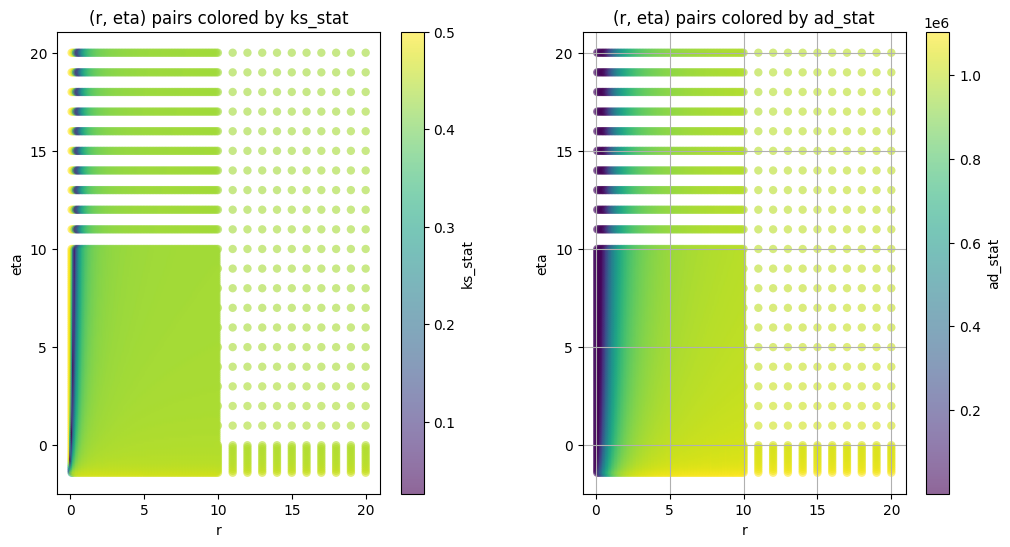

In [10]:
stats_df = all_cdfs_df.copy()
stats_df['ks_stat'] = [compute_ksstat(sample, cdf) for cdf in stats_df['cdf']]
stats_df['ad_stat'] = [compute_A2(sample, cdf) for cdf in stats_df['cdf']]
fig = create_scatter_plots(stats_df, 'ks_stat', 'ad_stat')
fig.tight_layout()

In [11]:
alpha_ks = 1e-10
alpha_ad = 1e-10
ks_cutoff = stats.kstwo.isf(alpha_ks, n)
ad_cutoff = scipy.optimize.fsolve(lambda x: 1 - evaluate_asymptotic_cdf(x, N=10) - alpha_ad, 1)[0]

stats_df['ks_pass'] = stats_df['ks_stat'] < ks_cutoff
stats_df['ad_pass'] = stats_df['ad_stat'] < ad_cutoff
stats_df['pass_summary'] = np.select(
    [(stats_df['ks_pass']) & (stats_df['ad_pass']), stats_df['ks_pass'], stats_df['ad_pass']],
    ['Both', 'Only KS', 'Only AD'], 'Neither'
)
stats_df['pass_summary'].value_counts()

pass_summary
Neither    12760
Name: count, dtype: int64

In [12]:
best_ks, best_ad = stats_df[['ks_stat', 'ad_stat']].min()

include_within = 4
union = stats_df[
    (stats_df['ks_stat'] / best_ks < 1 + include_within) | 
    (stats_df['ad_stat'] / best_ad < 1 + include_within)
]
min_r, min_eta = union[['r', 'eta']].min()
max_r, max_eta = union[['r', 'eta']].max()
r_pad, eta_pad = .05, .5
fine_stats_df = fine_cdfs_df[
    (fine_cdfs_df['r'] >= min_r - r_pad) &
    (fine_cdfs_df['r'] <= max_r + r_pad) &
    (fine_cdfs_df['eta'] >= min_eta - eta_pad) &
    (fine_cdfs_df['eta'] <= max_eta + eta_pad)
].copy()

fine_stats_df['ks_stat'] = [compute_ksstat(sample, cdf) for cdf in fine_stats_df['cdf']]
fine_stats_df['ad_stat'] = [compute_A2(sample, cdf) for cdf in fine_stats_df['cdf']]
fine_stats_df['ks_pass'] = fine_stats_df['ks_stat'] < ks_cutoff
fine_stats_df['ad_pass'] = fine_stats_df['ad_stat'] < ad_cutoff

best_ks, best_ad = fine_stats_df[['ks_stat', 'ad_stat']].min()
r_best_ks, eta_best_ks = fine_stats_df[fine_stats_df['ks_stat'] == best_ks][['r', 'eta']].iloc[0]
r_best_ad, eta_best_ad = fine_stats_df[fine_stats_df['ad_stat'] == best_ad][['r', 'eta']].iloc[0]

fine_union = fine_stats_df[
    (fine_stats_df['ks_stat'] / best_ks < 1 + include_within) | 
    (fine_stats_df['ad_stat'] / best_ad < 1 + include_within)
]
min_r, min_eta = fine_union[['r', 'eta']].min()
max_r, max_eta = fine_union[['r', 'eta']].max()
r_pad, eta_pad = r_pad / 2, eta_pad / 2
fine_stats_df = fine_stats_df[
    (fine_stats_df['r'] >= min_r - r_pad) &
    (fine_stats_df['r'] <= max_r + r_pad) &
    (fine_stats_df['eta'] >= min_eta - eta_pad) &
    (fine_stats_df['eta'] <= max_eta + eta_pad)
]

fine_stats_df['threshold_summary'] = np.select([
    (fine_stats_df['ks_stat'] / best_ks < 1 + include_within) & (fine_stats_df['ad_stat'] / best_ad < 1 + include_within), 
    fine_stats_df['ks_stat'] / best_ks < 1 + include_within,
    fine_stats_df['ad_stat'] / best_ad < 1 + include_within],
    ['Both', 'Only KS', 'Only AD'], 'Neither'
)

print(fine_stats_df['threshold_summary'].value_counts())
print(f'\nBest KS stat: {best_ks:.4f},       Best AD stat: {best_ad:.4f}')
best_ks_pval = 1 - stats.kstwo.cdf(best_ks, n)
best_ad_pval = 1 - evaluate_asymptotic_cdf(best_ad, N=10)
print(f'Best KS pval: {best_ks_pval:e}, Best AD pval: {best_ad_pval:e}')

threshold_summary
Neither    1609
Only KS      66
Both         14
Name: count, dtype: int64

Best KS stat: 0.0091,       Best AD stat: 52.3360
Best KS pval: 7.074119e-11, Best AD pval: 1.554312e-15


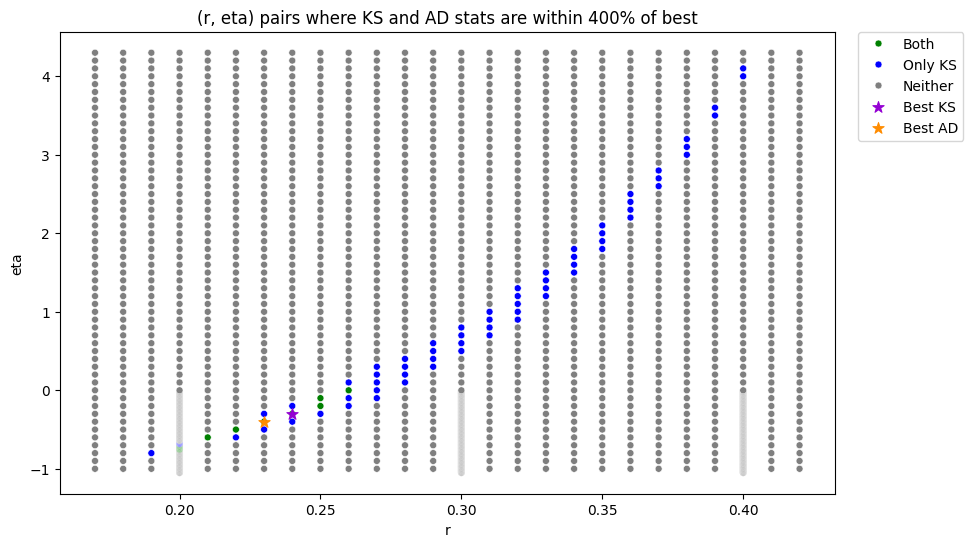

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    fine_stats_df,
    x='r',
    y='eta',
    s=25,
    hue='threshold_summary',
    palette={
        'Both': 'green',
        'Only KS': 'blue',
        'Only AD': 'gold',
        'Neither': 'tab:gray'
    }
)
sns.scatterplot(x=[r_best_ks], y=[eta_best_ks], marker='*', s=75, c='darkviolet', edgecolor=None, label='Best KS')
sns.scatterplot(x=[r_best_ad], y=[eta_best_ad], marker='*', s=75, c='darkorange', edgecolor=None, label='Best AD')

handles, labels = plt.gca().get_legend_handles_labels()
label_to_handle = dict(zip(labels, handles))
ordered_labels = list(filter(label_to_handle.__contains__, ['Both', 'Only KS', 'Only AD', 'Neither', 'Best KS', 'Best AD']))
ordered_handles = [label_to_handle[label] for label in ordered_labels]
plt.legend(ordered_handles, ordered_labels, bbox_to_anchor=(1.175, 1.015), loc='upper right')

alpha = alpha_ks if alpha_ks == alpha_ad else f'{(alpha_ks, alpha_ad)}, respectively'
plt.title(f'(r, eta) pairs where KS and AD stats are within {include_within:.0%} of best')
plt.show()